## Import Libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)

In [3]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## Import Data

In [4]:
df = pd.read_csv('./fmnist_small.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,9,0,0,0,0,0,0,0,0,0,...,0,7,0,50,205,196,213,165,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,142,142,142,21,0,3,0,0,0,0
3,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,...,213,203,174,151,188,10,0,0,0,0


In [5]:
df.shape

(6000, 785)

## Image Plotting

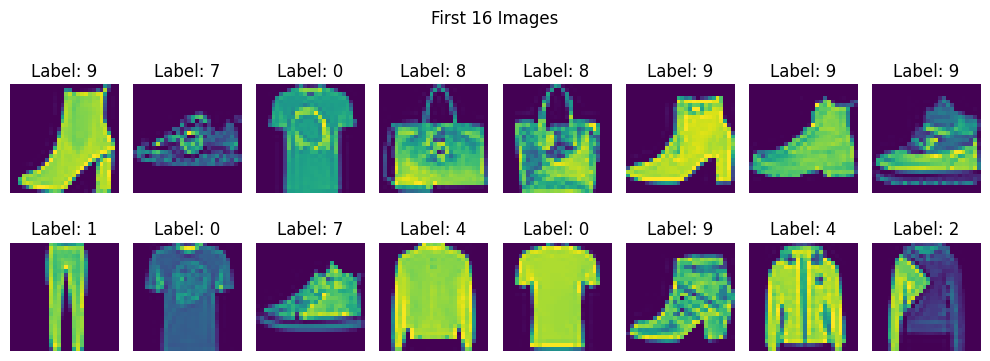

In [6]:
# Create a 4x4 grid of images
fig, axes = plt.subplots(2, 8, figsize=(10,4))
fig.suptitle("First 16 Images")

# Plot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
  img = df.iloc[i, 1:].values.reshape(28, 28)           # Reshape to 28x28
  ax.imshow(img)                                        # Display in grayscale 
  ax.axis('off')                                        # Remove axis for a cleaner look
  ax.set_title(f"Label: {df.iloc[i, 0]}")               # Show the label

plt.tight_layout(rect=[0, 0, 1, 1])                  # Adjust layout to fit the title
plt.show()   

## Data Processing

In [7]:
# train test split
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

X

array([[  0,   0,   0, ..., 165,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], shape=(6000, 784))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [9]:
# Feature Scaling
X_train = X_train/255.0
X_test = X_test/255.0

## DataLoader

In [10]:
# Create CustomDataset Class
class CustomDataset(Dataset):

  def __init__(self, features, labels):
    self.features = torch.tensor(features, dtype=torch.float32)
    self.labels = torch.tensor(labels, dtype=torch.long)

  def __len__(self):
    return len(self.features)
  
  def __getitem__(self, idx):
    return self.features[idx], self.labels[idx]

In [11]:
# Create train_dataset object
train_dataset = CustomDataset(X_train, y_train)
train_dataset[0]

(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0

In [12]:
# Create test_dataset object
test_dataset = CustomDataset(X_test, y_test)
len(test_dataset)

1200

In [13]:
# Create train and test loader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=True)

In [14]:
print(f"Number of Batches: {len(train_loader)}")

Number of Batches: 38


## Model Definition

In [15]:
# Model Definiton for HPT
class MyNN(nn.Module):

  def __init__(self, input_dim, output_dim, num_hidden_layers, neurons_per_layer):
    super().__init__()
    layers = []

    for i in range(num_hidden_layers):
      layers.append(nn.Linear(input_dim, neurons_per_layer))
      layers.append(nn.BatchNorm1d(neurons_per_layer))      
      layers.append(nn.ReLU())
      layers.append(nn.Dropout(p=0.3))
      input_dim = neurons_per_layer
    layers.append(nn.Linear(input_dim, output_dim))

    self.model = nn.Sequential(*layers)

  def forward(self, x):
    return self.model(x)

## Optuna Hyperparameter Tuning

In [16]:
# Objective Function
def objective(trial):

  # next hyperparameter values from the search space
  num_hidden_layers = trial.suggest_int("num_hidden_layers", 1, 5)
  neurons_per_layer = trial.suggest_int("neurons_per_layer", 8, 128, step=8)

  # model init
  input_dim = 784
  output_dim = 10

  model = MyNN(input_dim, output_dim, num_hidden_layers, neurons_per_layer)
  model = model.to(device)

  # params init
  learning_rate = 0.01
  epochs = 50

  # optimizer init
  loss_fn = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=5e-4)

  # training loop
  for epoch in range(epochs):
    for batch_features, batch_labels in train_loader:
      # Move batch data to gpu
      batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

      # forward pass
      outputs = model(batch_features)

      # calculate loss
      loss = loss_fn(outputs, batch_labels)

      # backward pass
      optimizer.zero_grad()
      loss.backward()

      # update parameters
      optimizer.step()

  # evaluation
  model.eval()
  total = 0
  correct = 0

  with torch.no_grad():
    for batch_features,batch_labels in test_loader:
      # Move batch data to gpu
      batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
      
      outputs = model(batch_features)
      _, predicted = torch.max(outputs, 1)
      total += batch_labels.shape[0]
      correct += (predicted==batch_labels).sum().item()
    accuracy = correct/total

  return accuracy

In [17]:
import optuna

study = optuna.create_study(direction='maximize')

/home/dhruv-kapri/Desktop/Projects/Pytorch/4 - ANN/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-12-20 15:44:26,831] A new study created in memory with name: no-name-08908400-95b4-4978-8124-6dec7c5e8f86


In [18]:
study.optimize(func=objective, n_trials=10)

[I 2025-12-20 15:44:32,309] Trial 0 finished with value: 0.825 and parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 128}. Best is trial 0 with value: 0.825.
[I 2025-12-20 15:44:37,091] Trial 1 finished with value: 0.8308333333333333 and parameters: {'num_hidden_layers': 3, 'neurons_per_layer': 128}. Best is trial 1 with value: 0.8308333333333333.
[I 2025-12-20 15:44:42,111] Trial 2 finished with value: 0.825 and parameters: {'num_hidden_layers': 3, 'neurons_per_layer': 72}. Best is trial 1 with value: 0.8308333333333333.
[I 2025-12-20 15:44:48,514] Trial 3 finished with value: 0.6208333333333333 and parameters: {'num_hidden_layers': 5, 'neurons_per_layer': 16}. Best is trial 1 with value: 0.8308333333333333.
[I 2025-12-20 15:44:52,690] Trial 4 finished with value: 0.7908333333333334 and parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 24}. Best is trial 1 with value: 0.8308333333333333.
[I 2025-12-20 15:44:55,928] Trial 5 finished with value: 0.8325 and parameters: {'

In [19]:
print(f'best value: {study.best_value}')
print(f'best parameters: {study.best_params}')

best value: 0.8325
best parameters: {'num_hidden_layers': 1, 'neurons_per_layer': 64}


## Training Pipeline

In [20]:
best_params = study.best_params

final_model = MyNN(
  input_dim = 784,
  output_dim = 10,
  num_hidden_layers = best_params['num_hidden_layers'],
  neurons_per_layer = best_params['neurons_per_layer']
).to(device)

optimizer = optim.SGD(
    final_model.parameters(),
    lr=0.01,
    weight_decay=5e-4
)

loss_fn = nn.CrossEntropyLoss()
epochs = 50

In [ ]:
# Final Training
for _ in range(epochs):
  for batch_features,batch_labels in train_loader:
    # Move batch data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
    
    # forward pass
    outputs = final_model(batch_features)
    
    # calculate loss
    loss = loss_fn(outputs, batch_labels)
    
    # backward pass
    optimizer.zero_grad()
    loss.backward()
    
    # update parameters
    optimizer.step()

## Evaluation

In [23]:
# evaluation code
def accuracy(model, loader):
  total = 0
  correct = 0

  with torch.no_grad():
    for batch_features,batch_labels in loader:
      # Move batch data to gpu
      batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
      
      outputs = model(batch_features)
      _, predicted = torch.max(outputs, 1)
      total += batch_labels.shape[0]
      correct += (predicted==batch_labels).sum().item()
  
  return correct/total

In [24]:
print(f'test accuracy: {accuracy(final_model, test_loader)}')
print(f'train accuracy: {accuracy(final_model, train_loader)}')

test accuracy: 0.7975
train accuracy: 0.8758333333333334


## Summary

In [25]:
from torchinfo import summary

summary(final_model, input_size=X_train.shape)    # input size parameter

Layer (type:depth-idx)                   Output Shape              Param #
MyNN                                     [4800, 10]                --
├─Sequential: 1-1                        [4800, 10]                --
│    └─Linear: 2-1                       [4800, 64]                50,240
│    └─BatchNorm1d: 2-2                  [4800, 64]                128
│    └─ReLU: 2-3                         [4800, 64]                --
│    └─Dropout: 2-4                      [4800, 64]                --
│    └─Linear: 2-5                       [4800, 10]                650
Total params: 51,018
Trainable params: 51,018
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 244.89
Input size (MB): 15.05
Forward/backward pass size (MB): 5.30
Params size (MB): 0.20
Estimated Total Size (MB): 20.56